In [1]:
"""%load_ext autoreload
%autoreload 2
%load_ext wurlitzer"""

import sys
import json
from ruamel.yaml import YAML
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import lossmaps as lm

from scipy.constants import c as clight

from cpymad.madx import Madx

import xpart as xp
import xtrack as xt
import xobjects as xo
import xdyna as xd
import xcoll as xc
# import xboinc as xb

# context = xo.ContextCpu(omp_num_threads=26)
context = xo.ContextCpu()

In [2]:
xc.__version__

'0.5.0'

In [4]:
align_angle = 10e-6

coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bending_radius = 80.00,
                            width=0.002, height=35.0e-3, side='+', lattice='strip', jaw=0.001)

"""coll = xc.EverestCrystal(length=0.004, material=xc.materials.SiliconCrystal, 
                         bending_radius = 80.00,  xdim = 2.0e-3,  ydim = 35.0e-3,  side='+', thick=0.0, miscut=0., lattice='strip', jaw_L=0.001, jaw_R=-0.001,
                         align_angle=align_angle, _context=context)"""
"""coll = xc.EverestCrystal(length = 0.070,  bending_radius = 10.00,  xdim = 2.0e-3,  ydim = 8.0e-3,  material=xc.materials.SiliconCrystal, 
                         side='+', thick=0.0, miscut=0., lattice='strip', jaw_L=0.001, jaw_R=-0.001,
                         align_angle=align_angle, _context=context)"""

# coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bend=0.002/149e-6,
#                          xdim=0.002, ydim=0.05, side='+', thick=0.0, miscut=0., lattice='strip', jaw_L=0.001, jaw_R=-0.001,
#                          align_angle=0.0, _context=context)

# coll = xc.EverestCollimator(length=0.004, material=xc.materials.Silicon, side='+', jaw_L=0.001, jaw_R=-0.001,
#                          _context=context)

num_part = int(1e6)
x_init   = np.random.normal(loc=1.5e-3, scale=75.e-6, size=num_part)
px_init  = np.random.uniform(low=-50.e-6, high=250.e-6, size=num_part)
y_init   = np.random.normal(loc=0., scale=1e-3, size=num_part)
py_init  = np.random.normal(loc=0., scale=5.e-6, size=num_part)
part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=6.8e12, _context=context)
# part._init_random_number_generator()
part_init = part.copy()

io_buffer = xt.new_io_buffer(capacity=int(2e7)) # 4-5 GB of memory
impacts = xt.start_internal_logging(elements=[coll], io_buffer=io_buffer, capacity=io_buffer.capacity)

In [5]:
coll.critical_angle

In [6]:
%time coll.track(part)


part_after = part.copy()

CPU times: user 407 ms, sys: 0 ns, total: 407 ms
Wall time: 408 ms


In [7]:
coll.critical_angle

1.8977386190295613e-06

In [8]:
# Sort particles again
part_after.sort(interleave_lost_particles=True)

In [9]:
d = 6773.7 - 6653.3 
#d = 1
line =  xt.Line(elements={'drift': xt.Drift(length = d)}, element_names=['drift'])
line.build_tracker()
line.track(part)

part_targ = part.copy()
part = part_after.copy()

In [10]:
# Sort particles again
part_targ.sort(interleave_lost_particles=True)

In [11]:
coll.critical_angle

1.8977386190295613e-06

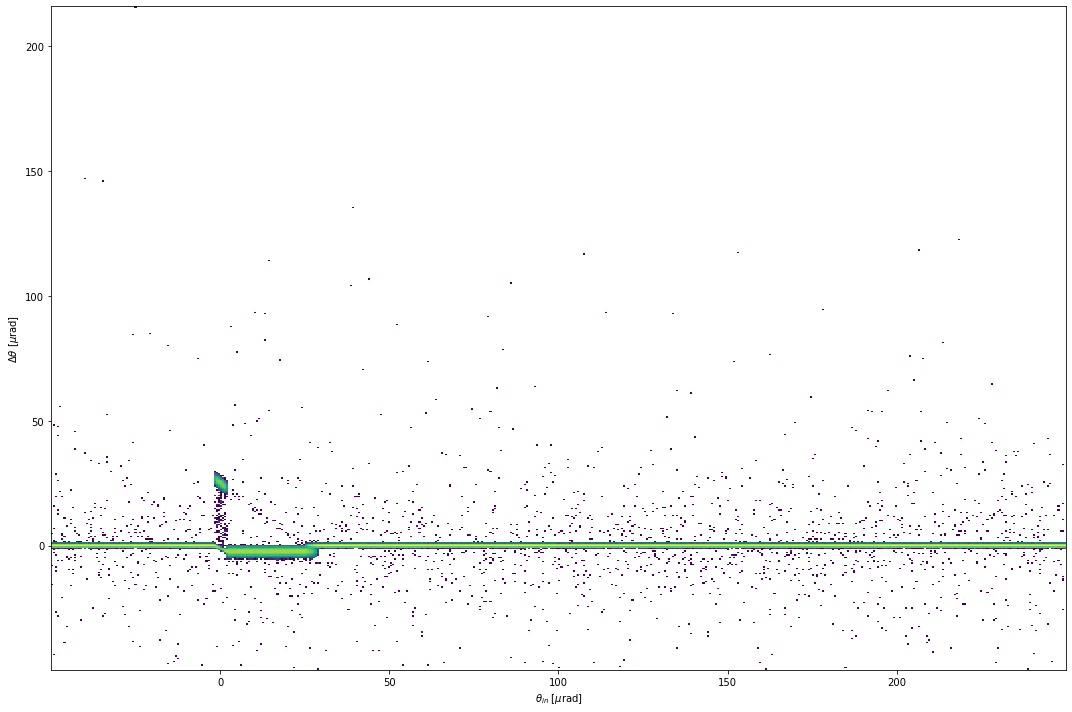

In [12]:
mask = (part.state > 0 ) & ( part.px - part_init.px < 250.e-6) & ( part.px - part_init.px > -50.e-6) #& mask2
# mask = (part.state > 0 ) & mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(15,10))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())

# smear_x = np.random.normal(loc=0., scale=5., size=len(part_init.px[mask]))
# smear_y = np.random.normal(loc=0., scale=2.8, size=len(part_init.px[mask]))
smear_x = 0
smear_y = 0
_ = plt.hist2d(part_init.px[mask]*1.e6+smear_x, part.px[mask]*1.e6 - part_init.px[mask]*1.e6 + smear_y, 500, norm=mpl.colors.LogNorm())
#plt.xlim(-30, 180)
#plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
# plt.savefig('cry_sixtrack.pdf', dpi=300)

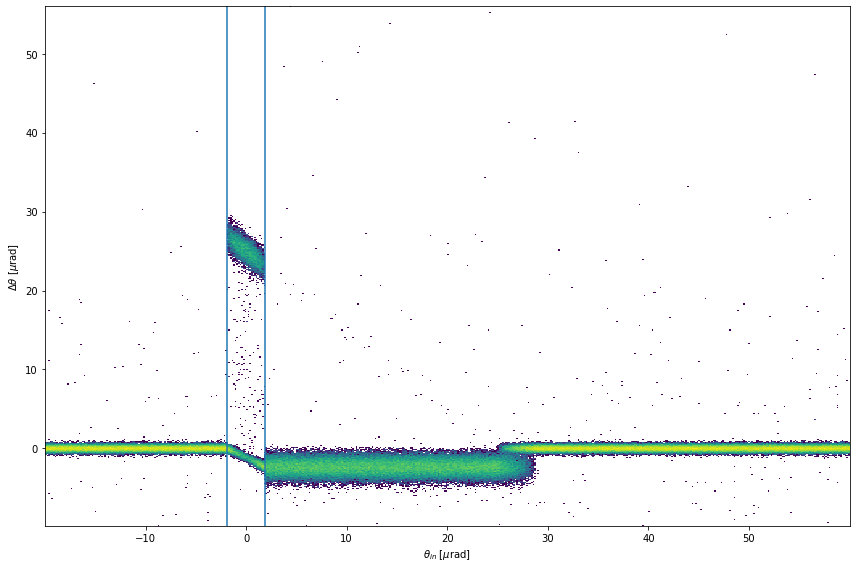

In [13]:
mask = (part.state > 0 ) & ( part.px - part_init.px < 60.e-6) & ( part.px - part_init.px > -10.e-6)  & (part_init.px < 60e-6) & (part_init.px > -20e-6)#& mask2
# mask = (part.state > 0 ) & mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(12,8))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())


_ = plt.hist2d(part_init.px[mask]*1.e6, part.px[mask]*1.e6 - part_init.px[mask]*1.e6, 500, norm=mpl.colors.LogNorm())
plt.axvline(coll.tilt*1e6 + coll.critical_angle*1e6, ymin=0, ymax=1)
plt.axvline(coll.tilt*1e6 - coll.critical_angle*1e6, ymin=0, ymax=1)
#plt.xlim(-10, 10)
#plt.ylim(-55, 100)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
# plt.savefig('cry_sixtrack.pdf', dpi=300)

In [14]:
df_imp = impacts.to_pandas()
len(part.state[part.state<0])

4244

In [15]:
df_imp

,turn,collimator_id,interaction_type,id_before,s_before,x_before,px_before,y_before,py_before,zeta_before,...,y_after,py_after,zeta_after,delta_after,energy_after,mass_after,charge_after,z_after,a_after,pdgid_after


In [13]:
df_imp[df_imp.parent_id == 100].iloc[-1][['parent_id', 'interaction_type', 'parent_x', 'parent_y', 'parent_px', 'parent_py', 'child_x', 'child_y', 'child_px', 'child_py']]

parent_id                100
interaction_type    Exit Jaw
parent_x            0.000498
parent_y            0.000581
parent_px           0.000218
parent_py                0.0
child_x                 -1.0
child_y                 -1.0
child_px                -1.0
child_py                -1.0
Name: 334, dtype: object

In [14]:
len( df_imp[df_imp.interaction_type == 'Rutherford'])

9

In [15]:
df_entry = df_imp[df_imp.interaction_type == 'Enter Jaw']
df_exit  = df_imp[df_imp.interaction_type == 'Exit Jaw']
df_entry = df_entry[~df_entry.parent_id.isin(np.unique(df_imp[df_imp.interaction_type == 'Absorbed'].parent_id))]
df_entry = df_entry.reset_index(drop=True)
df_exit = df_exit.reset_index(drop=True)
df_entry.parent_px = df_entry.parent_px + coll.align_angle
df_exit.parent_px = df_exit.parent_px + coll.align_angle
df_entry.parent_x = df_entry.parent_x + coll.jaw_L
df_exit.parent_x = df_exit.parent_x + coll.jaw_L


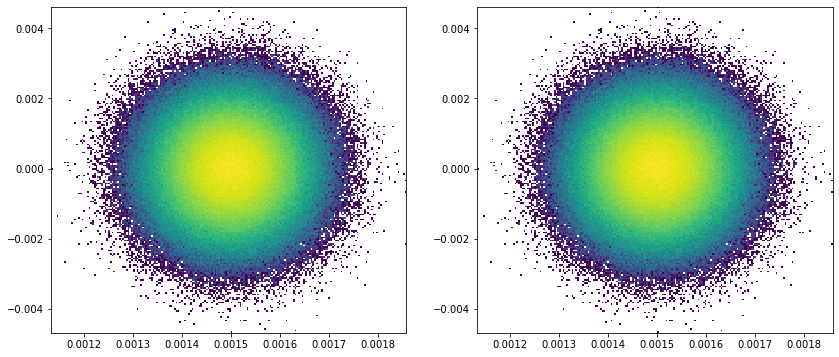

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
h = ax[0].hist2d(df_entry.parent_x, df_entry.parent_y, 200, norm=mpl.colors.LogNorm())
h2 = ax[1].hist2d(part_init.x, part_init.y, 200, norm=mpl.colors.LogNorm())
#plt.ylim(-20.e-6, 10.e-6)

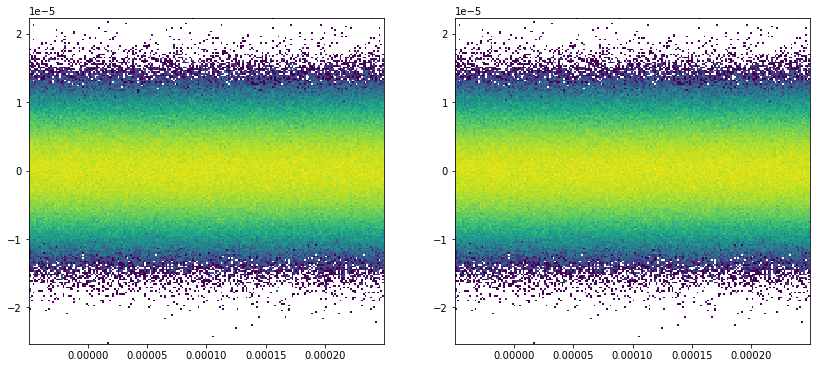

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
h = ax[0].hist2d(df_entry.parent_px, df_entry.parent_py, 200, norm=mpl.colors.LogNorm())
h2 = ax[1].hist2d(part_init.px, part_init.py, 200, norm=mpl.colors.LogNorm())

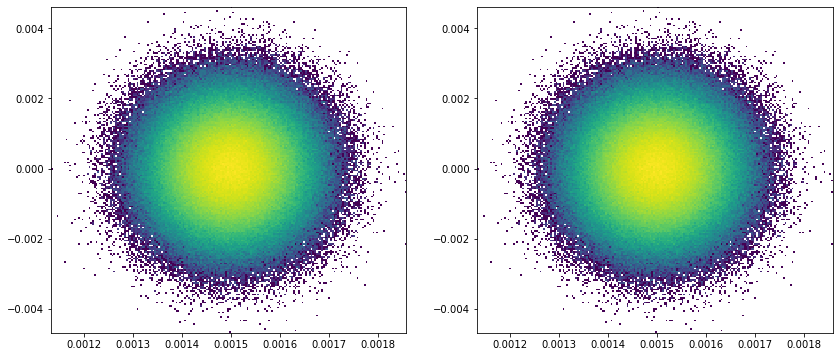

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
h = ax[0].hist2d(df_exit.parent_x, df_exit.parent_y, 200, norm=mpl.colors.LogNorm())
h2 = ax[1].hist2d(part.x, part.y, 200, norm=mpl.colors.LogNorm())

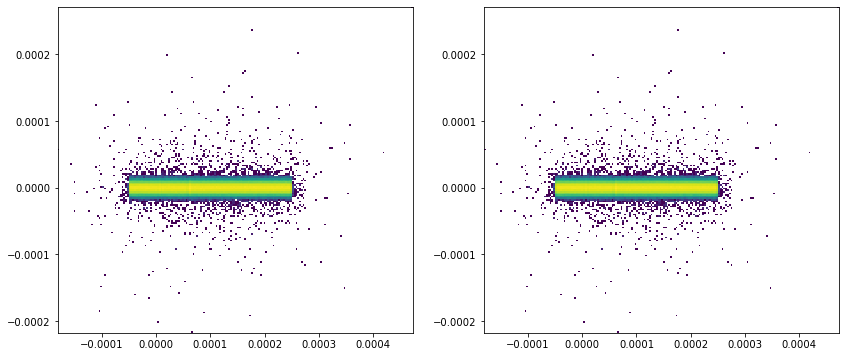

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
h = ax[0].hist2d(df_exit.parent_px, df_exit.parent_py, 200, norm=mpl.colors.LogNorm())
h2 = ax[1].hist2d(part.px, part.py, 200, norm=mpl.colors.LogNorm())

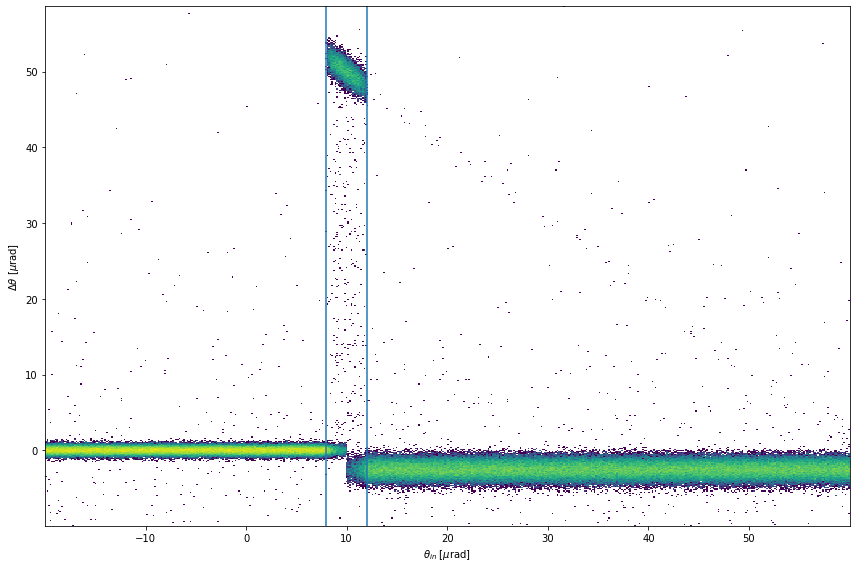

In [52]:
mask = ( df_exit.parent_px - df_entry.parent_px < 60.e-6) & ( df_exit.parent_px - df_entry.parent_px > -10.e-6)  & (df_entry.parent_px < 60e-6) & (df_entry.parent_px > -20e-6)#& mask2
# mask = (part.state > 0 ) & mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(12,8))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())


_ = plt.hist2d(df_entry.parent_px[mask]*1.e6, df_exit.parent_px[mask]*1.e6 - df_entry.parent_px[mask]*1.e6, 500, norm=mpl.colors.LogNorm())
plt.axvline(coll.align_angle*1e6 + coll.critical_angle*1e6, ymin=0, ymax=1)
plt.axvline(coll.align_angle*1e6 - coll.critical_angle*1e6, ymin=0, ymax=1)
#plt.xlim(-10, 10)
#plt.ylim(-55, 100)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
# plt.savefig('cry_sixtrack.pdf', dpi=300)

In [53]:
sum(round(df_entry.parent_px, 15) == np.round(part_init.px[(part.state > 0 )], 15)) == len(df_entry)

True

In [54]:
sum(round(df_entry.parent_x, 6) == np.round(part_init.x[(part.state > 0 )],6)) == len(df_entry)

True

In [55]:
pe =part.to_pandas()[(part.state > 0 )]
pe = pe.reset_index(drop=True)
m=round(df_exit.parent_x, 6) != np.round(part.x[(part.state > 0 )],6)

In [56]:
test1 = df_exit[round(df_exit.parent_x, 6) != np.round(part.x[(part.state > 0 )],6)]
test2 = pe[m]

In [57]:
n = 8
print(sum(round(test1.parent_y, n) == round(test2.y, n)))
n = 5
print(sum(round(test1.parent_x, n) == round(test2.x, n)))

39556
39556


In [50]:
pin =  part_init.to_pandas()
pin[['particle_id', 'x', 'y', 'px', 'py']]

,particle_id,x,y,px,py
0,0,0.001371,-0.001277,0.000172,0.000006
1,1,0.001501,-0.000624,0.000169,-0.000003
2,2,0.001524,-0.001352,0.000018,-0.000001
3,3,0.001502,-0.001174,0.000029,0.000007
4,4,0.001647,0.000910,0.000058,0.000002
...,...,...,...,...,...
999995,999995,0.001539,0.000711,0.000196,-0.000002
999996,999996,0.001475,-0.000025,0.000148,-0.000004
999997,999997,0.001502,0.000502,0.000010,0.000004
999998,999998,0.001420,-0.000859,0.000233,0.000004


In [27]:
pout =  part_init.to_pandas()
pout[['particle_id', 'x', 'y', 'px', 'py']]

,particle_id,x,y,px,py
0,0,0.001371,-0.001277,0.000172,0.000006
1,1,0.001501,-0.000624,0.000169,-0.000003
2,2,0.001524,-0.001352,0.000018,-0.000001
3,3,0.001502,-0.001174,0.000029,0.000007
4,4,0.001647,0.000910,0.000058,0.000002
...,...,...,...,...,...
999995,999995,0.001539,0.000711,0.000196,-0.000002
999996,999996,0.001475,-0.000025,0.000148,-0.000004
999997,999997,0.001502,0.000502,0.000010,0.000004
999998,999998,0.001420,-0.000859,0.000233,0.000004


(-2e-05, 1e-05)

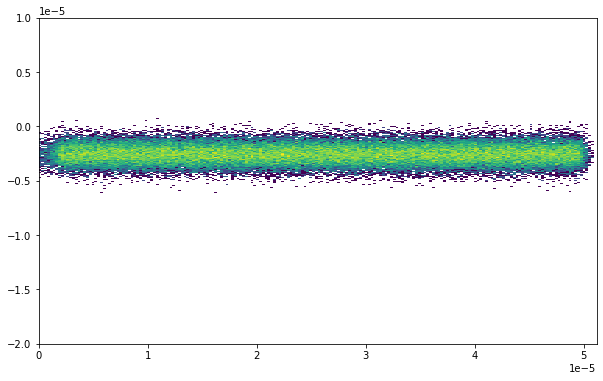

In [28]:
df3 = df_imp[df_imp.interaction_type == 'Volume Reflection']

plt.figure(figsize=(10,6))
_ = plt.hist2d(df3.parent_px, df3.child_px - df3.parent_px, 200, norm=mpl.colors.LogNorm())
plt.ylim(-20.e-6, 10.e-6)

(-0.0015, 0.0015)

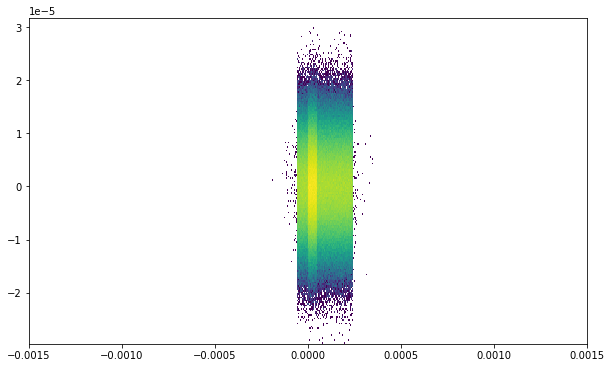

In [29]:
df3 = df_imp[df_imp.interaction_type == 'Multiple Coulomb Scattering']

plt.figure(figsize=(10,6))
_ = plt.hist2d(df3.parent_px, (df3.child_px - df3.parent_px) / np.sqrt(df3.ds), 200, norm=mpl.colors.LogNorm())
plt.xlim(-1.5e-3, 1.5e-3)
# plt.ylim(-30.e-6, 30.e-6)

In [30]:
type(impacts)

xcoll.impacts.impacts.CollimatorImpacts

In [31]:
df = impacts.interactions_per_collimator()
# df.loc[576926] = []
result = [inters for inters in df if inters[-1] == 'CH']
print(len(result))
#result


r2 = np.unique(result, return_counts=True)
print(r2[1].sum())
for inter, n in zip(r2[0], r2[1]):
    print(inter, n)

8254
8254
['CH'] 8189
['MCS', 'PN', 'MCS', 'VC', 'CH'] 1
['MCS', 'VC', 'CH'] 64


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [58]:
def int_list(ids, df=df):
    result = df[ids]
    r2 = np.unique(result, return_counts=True)
    print('Total number: ', r2[1].sum())
    for inter, n in zip(r2[0], r2[1]):
        print(inter, n)

In [59]:
chann_id = df.where(df.apply(lambda x: x == ['CH'])).dropna().index.to_list()
len(chann_id)

8189

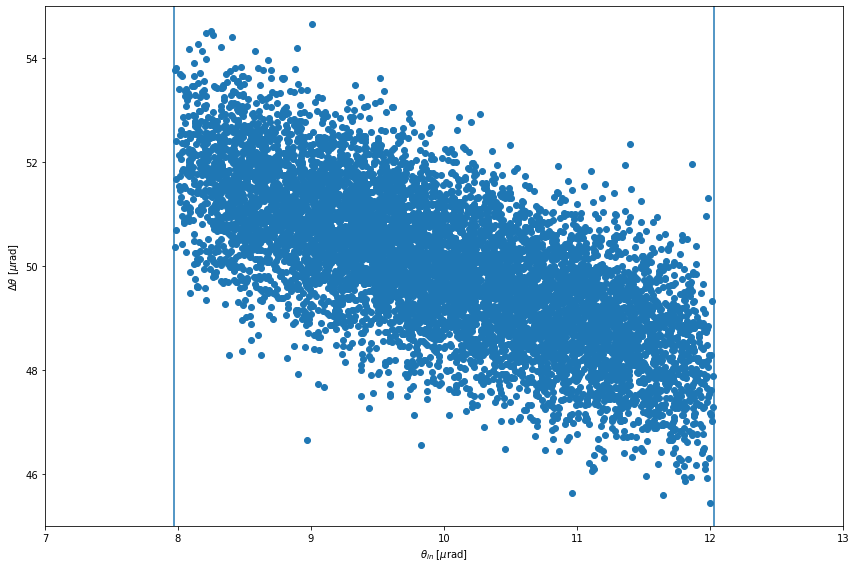

In [60]:
#mask = ( df_exit.parent_px - df_entry.parent_px < 60.e-6) & ( df_exit.parent_px - df_entry.parent_px > 40.e-6)  & (df_entry.parent_px < 20e-6) & (df_entry.parent_px > 0e-6)#& mask2
mask = (df_exit.parent_id.isin(chann_id))
# mask = (part.state > 0 ) & mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(12,8))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())


_ = plt.scatter(df_entry.parent_px[mask]*1.e6, df_exit.parent_px[mask]*1.e6 - df_entry.parent_px[mask]*1.e6)#, 500, norm=mpl.colors.LogNorm())
plt.axvline(coll.align_angle*1e6 + coll.critical_angle*1e6, ymin=0, ymax=1)
plt.axvline(coll.align_angle*1e6 - coll.critical_angle*1e6, ymin=0, ymax=1)
plt.xlim(7, 13)
plt.ylim(45, 55)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()

In [61]:
volcap_chann_id = df.where(df.apply(lambda x: x == ['MCS', 'VC', 'CH'])).dropna().index.to_list()
len(volcap_chann_id)

64

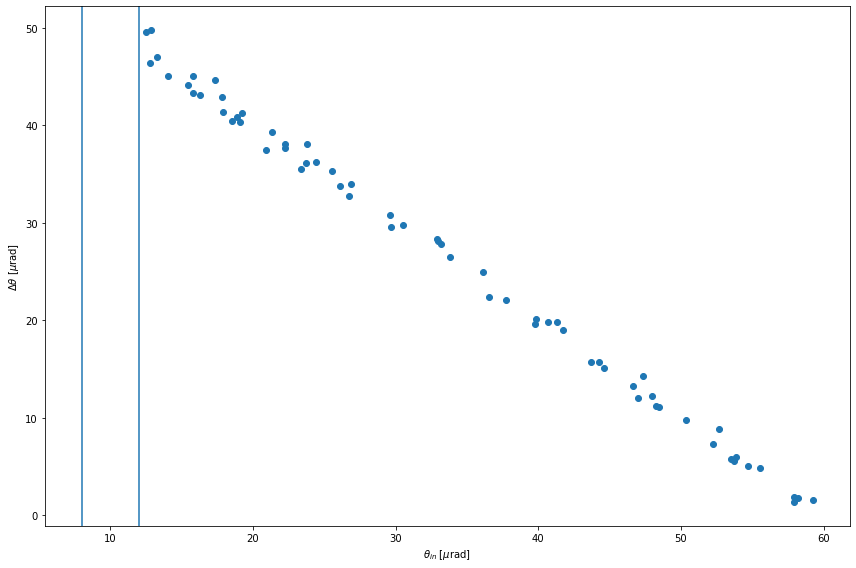

In [62]:
#mask = ( df_exit.parent_px - df_entry.parent_px < 60.e-6) & ( df_exit.parent_px - df_entry.parent_px > 40.e-6)  & (df_entry.parent_px < 20e-6) & (df_entry.parent_px > 0e-6)#& mask2
mask = (df_exit.parent_id.isin(volcap_chann_id))
# mask = (part.state > 0 ) & mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(12,8))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())


_ = plt.scatter(df_entry.parent_px[mask]*1.e6, df_exit.parent_px[mask]*1.e6 - df_entry.parent_px[mask]*1.e6)#, 500, norm=mpl.colors.LogNorm())
plt.axvline(coll.align_angle*1e6 + coll.critical_angle*1e6, ymin=0, ymax=1)
plt.axvline(coll.align_angle*1e6 - coll.critical_angle*1e6, ymin=0, ymax=1)
#plt.xlim(7, 13)
#plt.ylim(45, 55)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()

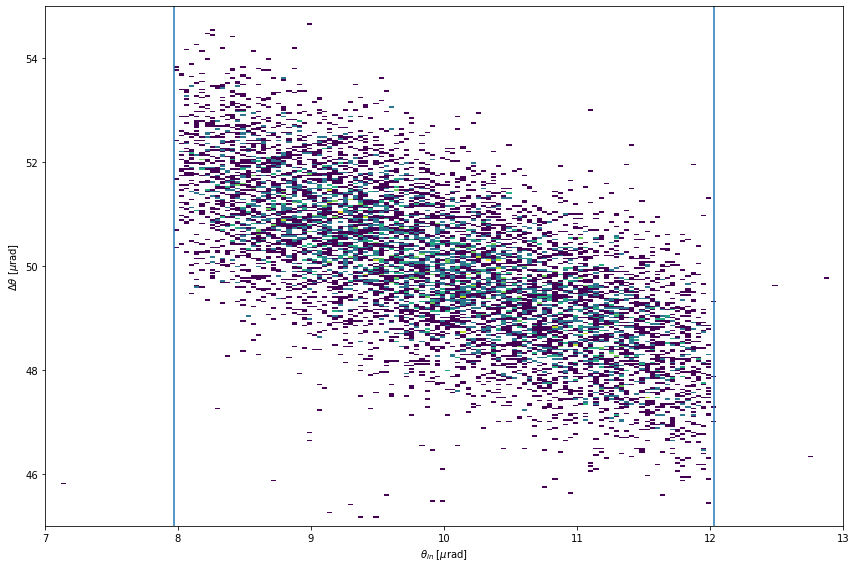

In [63]:
mask_dim = ( df_exit.parent_px - df_entry.parent_px < 60.e-6) & ( df_exit.parent_px - df_entry.parent_px > 40.e-6)  & (df_entry.parent_px < 20e-6) & (df_entry.parent_px > 0e-6)#& mask2
#mask = (df_exit.parent_id.isin(chann_id))
# mask = (part.state > 0 ) & mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(12,8))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())


_ = plt.hist2d(df_entry.parent_px[mask_dim]*1.e6, df_exit.parent_px[mask_dim]*1.e6 - df_entry.parent_px[mask_dim]*1.e6, 500, norm=mpl.colors.LogNorm())
plt.axvline(coll.align_angle*1e6 + coll.critical_angle*1e6, ymin=0, ymax=1)
plt.axvline(coll.align_angle*1e6 - coll.critical_angle*1e6, ymin=0, ymax=1)
plt.xlim(7, 13)
plt.ylim(45, 55)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()

In [64]:
print(r2[1].sum(), len(df_entry[mask_dim]), len(chann_id))

8254 8264 8189


In [65]:
int_list(df_entry[mask_dim].parent_id)

Total number:  8264
['CH'] 8189
['CH', 'DCH', 'MCS'] 36
['CH', 'DCH', 'MCS', 'VR', 'MCS'] 19
['CH', 'SD', 'MCS'] 1
['MCS', 'PP', 'MCS', 'VR', 'MCS'] 1
['MCS', 'SD', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VC', 'CH'] 16
['MCS', 'VR', 'MCS', 'PP', 'MCS'] 1


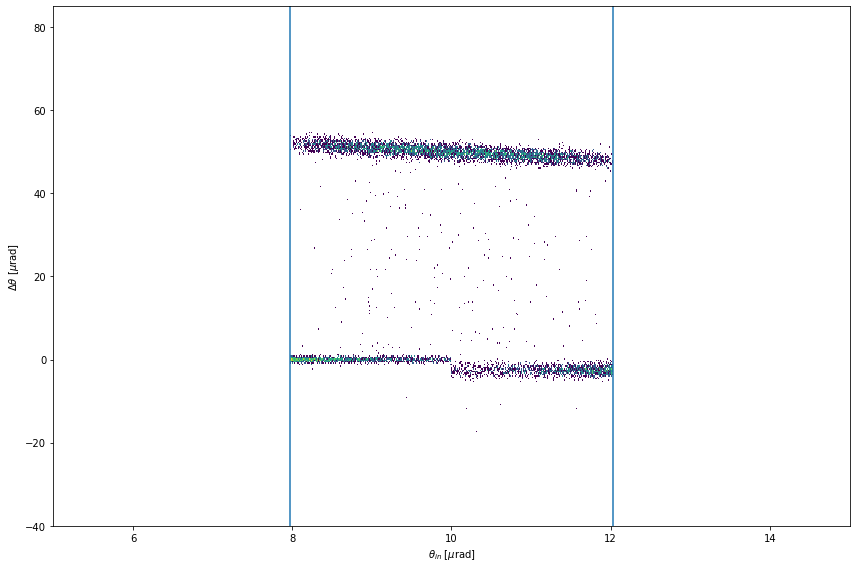

In [66]:
mask_xpcr = (df_entry.parent_px < coll.align_angle+coll.critical_angle) & (df_entry.parent_px > coll.align_angle - coll.critical_angle)#& mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(12,8))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())


_ = plt.hist2d(df_entry.parent_px[mask_xpcr]*1.e6, df_exit.parent_px[mask_xpcr]*1.e6 - df_entry.parent_px[mask_xpcr]*1.e6, 500, norm=mpl.colors.LogNorm())
plt.axvline(coll.align_angle*1e6 + coll.critical_angle*1e6, ymin=0, ymax=1)
plt.axvline(coll.align_angle*1e6 - coll.critical_angle*1e6, ymin=0, ymax=1)
plt.xlim(5, 15)
plt.ylim(-40, 85)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()

In [67]:
print(len(df_entry.parent_px[mask_xpcr]))

13505


In [68]:
int_list(df_entry.parent_id[mask_xpcr])

Total number:  13505
['CH'] 8189
['CH', 'DCH', 'MCS'] 162
['CH', 'DCH', 'MCS', 'VR', 'MCS'] 158
['CH', 'PN', 'MCS'] 4
['CH', 'PP', 'MCS'] 2
['CH', 'SD', 'MCS'] 1
['MCS'] 2514
['MCS', 'PN', 'MCS'] 7
['MCS', 'PP', 'MCS'] 2
['MCS', 'PP', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VC', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VR', 'MCS'] 2447
['MCS', 'VR', 'MCS', 'PN', 'MCS'] 10
['MCS', 'VR', 'MCS', 'PN', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VR', 'MCS', 'PP', 'MCS'] 2
['MCS', 'VR', 'MCS', 'PP', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VR', 'MCS', 'SD', 'MCS'] 3


In [69]:
result = df[df_entry.parent_id[mask_xpcr]]
r2 = np.unique(result, return_counts=True)
print('Total number: ', r2[1].sum())
int_df = pd.DataFrame({'int': r2[0], 'n': r2[1]})
int_df

Total number:  13505


,int,n
0,[CH],8189
1,"[CH, DCH, MCS]",162
2,"[CH, DCH, MCS, VR, MCS]",158
3,"[CH, PN, MCS]",4
4,"[CH, PP, MCS]",2
5,"[CH, SD, MCS]",1
6,[MCS],2514
7,"[MCS, PN, MCS]",7
8,"[MCS, PP, MCS]",2
9,"[MCS, PP, MCS, VR, MCS]",1


In [70]:
ch = 0
dech = 0
for i in range(len(int_df)):
    if int_df.iloc[i]['int'][-1] == 'CH':
        ch = ch +int_df.iloc[i]['n']
    elif 'DCH' in int_df.iloc[i]['int']:
        dech = dech + int_df.iloc[i]['n']
print(ch/sum(int_df['n']))
print(ch/(dech+ch))

0.6063680118474639
0.9623927606064168


In [71]:
r2[0], r2[1]

(array([list(['CH']), list(['CH', 'DCH', 'MCS']),
        list(['CH', 'DCH', 'MCS', 'VR', 'MCS']), list(['CH', 'PN', 'MCS']),
        list(['CH', 'PP', 'MCS']), list(['CH', 'SD', 'MCS']),
        list(['MCS']), list(['MCS', 'PN', 'MCS']),
        list(['MCS', 'PP', 'MCS']),
        list(['MCS', 'PP', 'MCS', 'VR', 'MCS']),
        list(['MCS', 'VC', 'MCS', 'VR', 'MCS']),
        list(['MCS', 'VR', 'MCS']),
        list(['MCS', 'VR', 'MCS', 'PN', 'MCS']),
        list(['MCS', 'VR', 'MCS', 'PN', 'MCS', 'VR', 'MCS']),
        list(['MCS', 'VR', 'MCS', 'PP', 'MCS']),
        list(['MCS', 'VR', 'MCS', 'PP', 'MCS', 'VR', 'MCS']),
        list(['MCS', 'VR', 'MCS', 'SD', 'MCS'])], dtype=object),
 array([8189,  162,  158,    4,    2,    1, 2514,    7,    2,    1,    1,
        2447,   10,    1,    2,    1,    3]))

In [72]:
part_targ.x[np.isin(part_targ.particle_id, chann_id) &(part_targ.state>0)]

array([0.0087263 , 0.00874473, 0.00872921, ..., 0.00891578, 0.0089823 ,
       0.00884878])

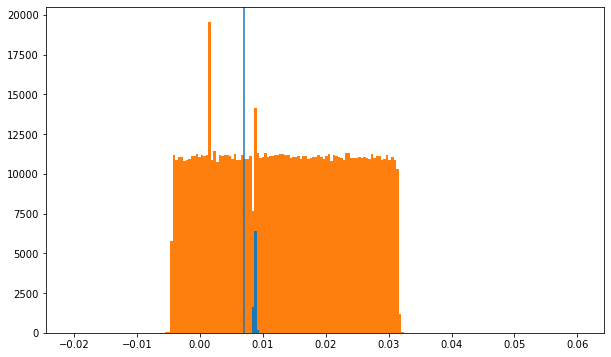

In [73]:
plt.figure(figsize=(10,6))
data = [part_targ.x[np.isin(part_targ.particle_id, chann_id) &(part_targ.state>0)], part_targ.x[~(np.isin(part_targ.particle_id, chann_id) &(part_targ.state>0))]]
_ = plt.hist(data, 200, stacked=True) #plt.hist2d(part_targ.x, part_targ.y, 200, norm=mpl.colors.LogNorm())
plt.axvline(d*50e-6+coll.jaw_L)
#plt.xlim(-1.5e-3, 1.5e-3)
# plt.ylim(-30.e-6, 30.e-6)

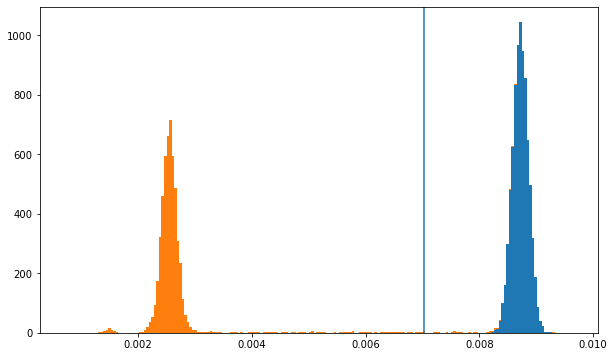

In [90]:
plt.figure(figsize=(10,6))
f = (part_targ.x >0) & (part_targ.x<0.01)
mpx = (part_init.px < coll.align_angle + coll.critical_angle) & ( part_init.px > coll.align_angle - coll.critical_angle)
data = [part_targ.x[np.isin(part_targ.particle_id, chann_id) &(part_targ.state>0) & mpx &f], part_targ.x[~(np.isin(part_targ.particle_id, chann_id) &(part_targ.state>0)) & mpx & f]]
_ = plt.hist(data, 200, stacked=True) #plt.hist2d(part_targ.x, part_targ.y, 200, norm=mpl.colors.LogNorm())
plt.axvline(d*50e-6+coll.jaw_L)

In [92]:
int_list(part_targ.particle_id[(part_targ.state>0) & mpx &f])

Total number:  13500
['CH'] 8189
['CH', 'DCH', 'MCS'] 162
['CH', 'DCH', 'MCS', 'VR', 'MCS'] 158
['CH', 'PN', 'MCS'] 4
['CH', 'PP', 'MCS'] 2
['CH', 'SD', 'MCS'] 1
['MCS'] 2514
['MCS', 'PN', 'MCS'] 7
['MCS', 'PP', 'MCS'] 1
['MCS', 'PP', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VC', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VR', 'MCS'] 2447
['MCS', 'VR', 'MCS', 'PN', 'MCS'] 9
['MCS', 'VR', 'MCS', 'PN', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VR', 'MCS', 'PP', 'MCS'] 1
['MCS', 'VR', 'MCS', 'PP', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VR', 'MCS', 'SD', 'MCS'] 1


In [74]:
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit(data):

    hist, bins = np.histogram(data, bins=100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    initial_guess = [np.max(hist), np.mean(data), np.std(data)]
    popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)
    return popt

def fit_gaussian(data, ax, xlims = None):
  
    fit_data = fit(data)
    
    if xlims is None:
        xmin, xmax = ax.get_xlim()
    else:
        xmin, xmax = xlims[0], xlims[1]
    x = np.linspace(xmin, xmax, 100)


    hist_values = [rect.get_height() for rect in ax.patches]
    bin_edges = [rect.get_x() for rect in ax.patches]

    # Calculate the area of the histogram
    bin_widths = np.diff(bin_edges)  
    bin_widths = np.append(bin_widths, 0) 
    hist_area = np.sum(hist_values * bin_widths) 
    print()


    tmp_y = gaussian(x, fit_data[0], fit_data[1], fit_data[2])
    funct_area = np.trapz(tmp_y, x=x)

    ax.plot(x, gaussian(x, fit_data[0]/funct_area*hist_area, fit_data[1], fit_data[2]), 'g', linestyle = '-', linewidth=2)
    print('mean: ', fit_data[1], 'std: ', fit_data[2])



mean:  0.008722767607021124 std:  0.00014316627742883483


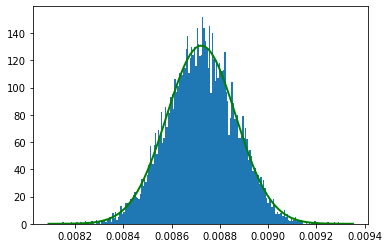

In [75]:
fig, ax = plt.subplots()
ax.hist(part_targ.x[np.isin(part_targ.particle_id, chann_id)], 200)
fit_gaussian(part_targ.x[np.isin(part_targ.particle_id, chann_id)], ax)



mean:  0.0015007064007686469 std:  7.528167821766684e-05


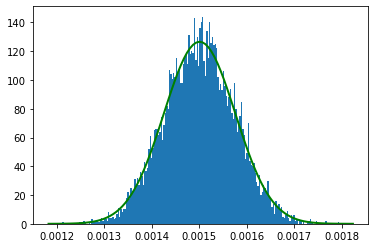

In [76]:
fig, ax = plt.subplots()
ax.hist(part_after.x[np.isin(part_after.particle_id, chann_id)], 200)
fit_gaussian(part_after.x[np.isin(part_after.particle_id, chann_id)], ax)

In [77]:
0.00872604753748179 - 0.0014995880655784995 

0.007226459471903291

In [78]:
coll.bending_angle*d  +   0.0014995880655784995  #+coll.jaw_L

0.007519588068086815

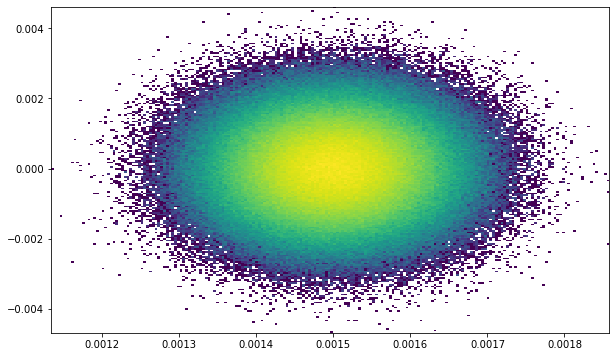

In [79]:
plt.figure(figsize=(10,6))
_ = plt.hist2d(part_after.x, part_after.y, 200, norm=mpl.colors.LogNorm())
#plt.xlim(-1.5e-3, 1.5e-3)
# plt.ylim(-30.e-6, 30.e-6)

Chann efficiency:  0.6082252686180066


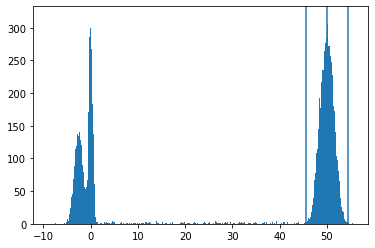

In [80]:
fig, ax = plt.subplots()
mask2 = (part_after.px - part_init.px <65e-6) & (part_after.px - part_init.px >-10e-6)
mask = (part_after.state > 0 ) & ( part_init.px < coll.align_angle + coll.critical_angle) & ( part_init.px > coll.align_angle - coll.critical_angle) & mask2
_ = ax.hist(part_after.px[mask]*1.e6 - part_init.px[mask]*1.e6, 500)
ax.axvline(coll.bending_angle*1e6)
data  = part_after.px[mask] - part_init.px[mask]
m = data > 45e-6
sig = fit(data[m])[2]
ax.axvline((coll.bending_angle+3*sig)*1e6)
ax.axvline((coll.bending_angle-3*sig)*1e6)
#fit_gaussian(data[m], ax, [45, 60])
ch = len(data[(data>coll.bending_angle-3*sig)&(data<coll.bending_angle+3*sig)])
print("Chann efficiency: ", ch/len(data))

In [1]:
24*4

96

In [82]:
m_xpcr = (part_after.state > 0 ) & ( part_init.px < coll.align_angle + coll.critical_angle) & ( part_init.px > coll.align_angle - coll.critical_angle)
m_3sig = ((part_after.px - part_init.px)>coll.bending_angle-3*sig)&((part_after.px - part_init.px)<coll.bending_angle+3*sig)
int_list(part_after.particle_id[m_xpcr & m_3sig])

Total number:  8208
['CH'] 8185
['CH', 'DCH', 'MCS'] 16
['CH', 'DCH', 'MCS', 'VR', 'MCS'] 6
['CH', 'SD', 'MCS'] 1


In [83]:
int_list(part_after.particle_id[m_xpcr])

Total number:  13505
['CH'] 8189
['CH', 'DCH', 'MCS'] 162
['CH', 'DCH', 'MCS', 'VR', 'MCS'] 158
['CH', 'PN', 'MCS'] 4
['CH', 'PP', 'MCS'] 2
['CH', 'SD', 'MCS'] 1
['MCS'] 2514
['MCS', 'PN', 'MCS'] 7
['MCS', 'PP', 'MCS'] 2
['MCS', 'PP', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VC', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VR', 'MCS'] 2447
['MCS', 'VR', 'MCS', 'PN', 'MCS'] 10
['MCS', 'VR', 'MCS', 'PN', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VR', 'MCS', 'PP', 'MCS'] 2
['MCS', 'VR', 'MCS', 'PP', 'MCS', 'VR', 'MCS'] 1
['MCS', 'VR', 'MCS', 'SD', 'MCS'] 3


In [84]:
int_list(part_after.particle_id[~m_xpcr])

Total number:  986495
['CH', 'A'] 18
['CH', 'DCH', 'MCS', 'A'] 2
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'A'] 2
['MCS'] 815830
['MCS', 'A'] 7788
['MCS', 'PN', 'MCS'] 2615
['MCS', 'PN', 'MCS', 'A'] 14
['MCS', 'PN', 'MCS', 'PN', 'MCS'] 8
['MCS', 'PN', 'MCS', 'PP', 'MCS', 'VR', 'MCS'] 1
['MCS', 'PN', 'MCS', 'VC', 'CH'] 1
['MCS', 'PN', 'MCS', 'VR', 'MCS'] 208
['MCS', 'PN', 'MCS', 'VR', 'MCS', 'A'] 2
['MCS', 'PP', 'MCS'] 650
['MCS', 'PP', 'MCS', 'A'] 3
['MCS', 'PP', 'MCS', 'PN', 'MCS'] 1
['MCS', 'PP', 'MCS', 'PP', 'MCS'] 1
['MCS', 'PP', 'MCS', 'VR', 'MCS'] 45
['MCS', 'RU', 'MCS'] 7
['MCS', 'RU', 'MCS', 'VR', 'MCS'] 1
['MCS', 'SD', 'MCS'] 548
['MCS', 'SD', 'MCS', 'A'] 3
['MCS', 'SD', 'MCS', 'PN', 'MCS'] 1
['MCS', 'SD', 'MCS', 'VR', 'MCS'] 42
['MCS', 'SD', 'MCS', 'VR', 'MCS', 'A'] 1
['MCS', 'VC', 'CH'] 64
['MCS', 'VC', 'CH', 'DCH', 'MCS'] 1
['MCS', 'VC', 'MCS'] 9
['MCS', 'VC', 'MCS', 'VR', 'MCS'] 7
['MCS', 'VR', 'MCS'] 157283
['MCS', 'VR', 'MCS', 'A'] 713
['MCS', 'VR', 'MCS', 'PN', 'MCS'] 240
['MCS

In [85]:
ch_out = df[~m_xpcr].where(df[~m_xpcr].apply(lambda x: x == ['CH'])).dropna().index.to_list()
len(ch_out)

0

In [36]:
# da controllare da qui in giu

In [86]:
result = np.unique(df.values, return_counts=True)
print(result[1].sum())
for inter, n in zip(result[0], result[1]):
    print(inter, n)

1000000
['CH'] 8189
['CH', 'A'] 18
['CH', 'DCH', 'MCS'] 162
['CH', 'DCH', 'MCS', 'A'] 2
['CH', 'DCH', 'MCS', 'VR', 'MCS'] 158
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'A'] 2
['CH', 'PN', 'MCS'] 4
['CH', 'PP', 'MCS'] 2
['CH', 'SD', 'MCS'] 1
['MCS'] 818344
['MCS', 'A'] 7788
['MCS', 'PN', 'MCS'] 2622
['MCS', 'PN', 'MCS', 'A'] 14
['MCS', 'PN', 'MCS', 'PN', 'MCS'] 8
['MCS', 'PN', 'MCS', 'PP', 'MCS', 'VR', 'MCS'] 1
['MCS', 'PN', 'MCS', 'VC', 'CH'] 1
['MCS', 'PN', 'MCS', 'VR', 'MCS'] 208
['MCS', 'PN', 'MCS', 'VR', 'MCS', 'A'] 2
['MCS', 'PP', 'MCS'] 652
['MCS', 'PP', 'MCS', 'A'] 3
['MCS', 'PP', 'MCS', 'PN', 'MCS'] 1
['MCS', 'PP', 'MCS', 'PP', 'MCS'] 1
['MCS', 'PP', 'MCS', 'VR', 'MCS'] 46
['MCS', 'RU', 'MCS'] 7
['MCS', 'RU', 'MCS', 'VR', 'MCS'] 1
['MCS', 'SD', 'MCS'] 548
['MCS', 'SD', 'MCS', 'A'] 3
['MCS', 'SD', 'MCS', 'PN', 'MCS'] 1
['MCS', 'SD', 'MCS', 'VR', 'MCS'] 42
['MCS', 'SD', 'MCS', 'VR', 'MCS', 'A'] 1
['MCS', 'VC', 'CH'] 64
['MCS', 'VC', 'CH', 'DCH', 'MCS'] 1
['MCS', 'VC', 'MCS'] 9
['MCS', 'V

In [25]:
mask1 = ['PP' in proc or 'PN' in proc or 'SD' in proc or 'RU' in proc or 'A' in proc for proc in df.sort_index().values]
mask1 = [proc != ['DRVI', 'VR', 'VRAM', 'MCS'] for proc in df.sort_index().values]
mask2 = ['AMVR' in proc for proc in df.sort_index().values]

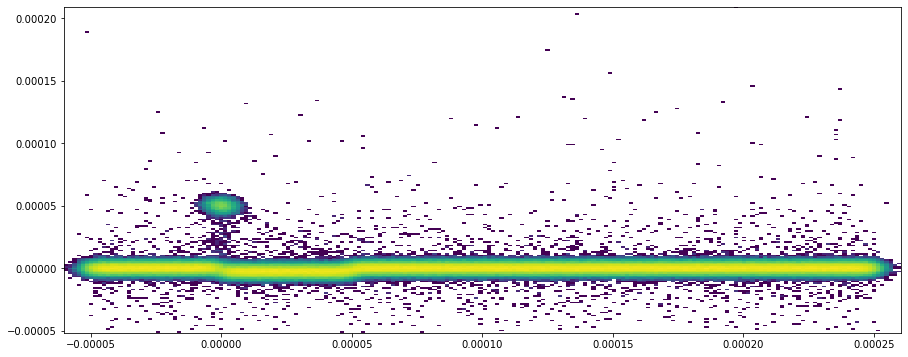

In [26]:
mask = (part.state > 0 ) & ( part.px - part_init.px < 250.e-6) & ( part.px - part_init.px > -50.e-6) #& mask2

plt.figure(figsize=(15,6))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())

smear_x = np.random.normal(loc=0., scale=2.8e-6, size=len(part_init.px[mask]))
smear_y = np.random.normal(loc=0., scale=2.8e-6, size=len(part_init.px[mask]))
#smear_x = 0
#smear_y = 0
_ = plt.hist2d(part_init.px[mask]+smear_x, part.px[mask] - part_init.px[mask] + smear_y, 200, norm=mpl.colors.LogNorm())
# plt.ylim(-50.e-6, 50.e-6)
# plt.xlim(130.e-6, 170.e-6)
# plt.ylim(-50.e-6, 20.e-6)

In [81]:
short_inter = []
for inter in result[0]:
    short_inter += [ inter[:2] ]
np.unique(short_inter)

/home/fvanderv/miniconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


array([list(['CH']), list(['CH', 'A']), list(['CH', 'DCH']),
       list(['CH', 'PN']), list(['CH', 'PP']), list(['CH', 'RU']),
       list(['CH', 'SD']), list(['MCS']), list(['MCS', 'A']),
       list(['MCS', 'PN']), list(['MCS', 'PP']), list(['MCS', 'RU']),
       list(['MCS', 'SD']), list(['VRAM', 'MCS']), list(['VRCH', 'MCS'])],
      dtype=object)

In [17]:
Nc = 0
Nd = 0
Nca = 0
Ncn = 0
for inter, n in zip(result[0], result[1]):
    if inter[0] == 'CH':
        Nc += n
        if len(inter) >1:
            if inter[1] == 'DCH':
                Nd += n
            elif inter[1] == 'A':
                Nca += n
            elif inter[1] == 'PN' or inter[1] == 'PP' or inter[1] == 'RU' or inter[1] == 'SD':
                Ncn += n
print(f"Nc: {Nc/1e6:.1%}, of which:  Nca: {Nca/Nc:.1%},  Nd: {Nd/Nc:.1%},  Ncn: {Ncn/Nc:.1%}")

Nc: 0.0%, of which:  Nca: 0.0%,  Nd: 0.0%,  Ncn: 0.0%


1.4928213486648864e-07


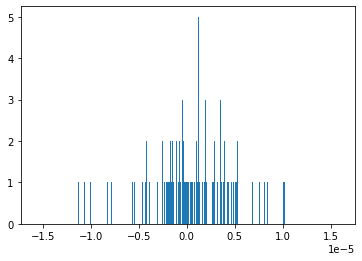

In [18]:
df2 = impacts.to_pandas()
df3 = df2[df2.interaction_type == 'Multiple Coulomb Scattering']
print(np.mean(df3['parent_px'] - df3['child_px']))

_ = plt.hist(df3['parent_px'] - df3['child_px'], 500)

In [19]:
df2 = impacts.to_pandas()
df2[df2['parent_id'] == 999996]

,turn,collimator id,interaction_type,ds,parent_id,parent_x,parent_px,parent_y,parent_py,parent_zeta,...,child_y,child_py,child_zeta,child_delta,child_energy,child_mass,child_charge,child_z,child_a,child_pdgid
